### Import neccessary packages ###

In [3]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Read the file ###

In [4]:
# load the file
gg_data = pd.read_csv('google.csv', keep_default_na=False)


In [5]:
# Check the initial shape of the data. The result is 2930 rows, 82 columns
print ('Initial shape of the gg_data is', gg_data.shape)


Initial shape of the houseData is (2768, 7)


In [6]:
# See the initial data types of each columns
gg_data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
# Check duplicates row in dataframe. The result is we find no duplicates in the data row.
gg_data[gg_data.duplicated(keep=False)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [8]:
# Removing spaces from column names to have better access
gg_data.columns = gg_data.columns.str.replace(' ',"")

# Change the empty field into NAN
gg_data.replace(to_replace = "", value = np.NAN,inplace=True)

# See all the columns in dataframe 
gg_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')

In [9]:
# Check how many columns contains empty value (empty row)
gg_data.columns[gg_data.isnull().sum() != 0].size

0

In [10]:
# Display which columns has empty value (empty row)
gg_data.columns[gg_data.isnull().sum() != 0]

Index([], dtype='object')

In [11]:
# See how many values are empty in each column which has empty value (empty row)
gg_data.loc[:,gg_data.columns[gg_data.isnull().sum() != 0]].isnull().sum().sort_values()

Series([], dtype: float64)

## DATA CLEANING ##

In [13]:
gg_data.sample(10)

,Date,Open,High,Low,Close,AdjClose,Volume
2253,2017-06-09,984.500000,984.500000,935.630005,949.830017,949.830017,3309400
1278,2013-07-26,440.629120,442.119446,438.150269,439.814423,439.814423,3578400
2283,2017-07-24,972.219971,986.200012,970.770020,980.340027,980.340027,3248300
1677,2015-02-26,540.237061,553.096313,538.536377,552.439880,552.439880,2311500
1632,2014-12-19,508.712830,514.888855,504.138977,513.526367,513.526367,3700300
1856,2015-11-10,724.400024,730.590027,718.500000,728.320007,728.320007,1608000
2060,2016-09-01,769.250000,771.020020,764.299988,768.780029,768.780029,925100
473,2010-05-14,253.237930,253.843994,246.521622,252.125168,252.125168,8285500
321,2009-10-06,244.261322,248.071533,244.261322,247.758575,247.758575,5500100
596,2010-11-08,309.993774,312.711121,309.551666,311.359894,311.359894,4229900


In [14]:
# Set Order column as index
gg_data.set_index('Date', inplace=True)

## DATA OBSERVATION ##

O foco aqui é a coluna close, referente ao preço de fechamento, vamos ver quais colunas tem mais corelaç~ao com ela, utilizando a biblioteca seaborn e a função heatmap.

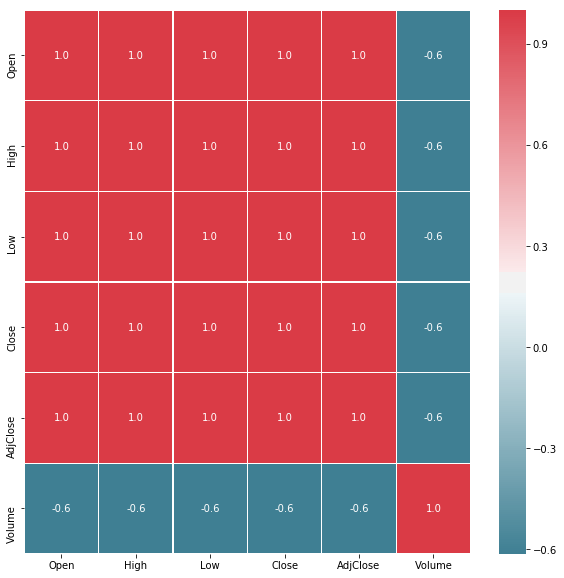

In [18]:
# Display the correlation heatmap

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
colormap = sbn.diverging_palette(220, 10, as_cmap=True)
sbn.heatmap(gg_data.corr(), cmap=colormap, annot=True, linewidths=.05, fmt='.1f', ax=ax)

In [19]:
# Sorted the most important features correlated to Sale Price
corr = gg_data.corr() #perason correlation 
corr.sort_values(["Close"], ascending = False, inplace = True)
print("Most important feature by perason correlation")
print(corr.Close)

Most important feature by perason correlation
Close       1.000000
AdjClose    1.000000
Low         0.999873
High        0.999835
Open        0.999681
Volume     -0.610806
Name: Close, dtype: float64


Based on correlation heatmap above, some features which has high correlation with 'SalePrice' are: OverallQual,GrLivArea,ExterQual, KitchenQual, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, BsmtQual This correlation will be proven after we run our algorithm modelling.

In [20]:
# Show the correlation summary
gg_data.corr()

,Open,High,Low,Close,AdjClose,Volume
Open,1.000000,0.999870,0.999819,0.999681,0.999681,-0.609923
High,0.999870,1.000000,0.999789,0.999835,0.999835,-0.607476
Low,0.999819,0.999789,1.000000,0.999873,0.999873,-0.613540
Close,0.999681,0.999835,0.999873,1.000000,1.000000,-0.610806
AdjClose,0.999681,0.999835,0.999873,1.000000,1.000000,-0.610806
Volume,-0.609923,-0.607476,-0.613540,-0.610806,-0.610806,1.000000


We try to get some information from the dependant variable  (column 'SalePrice').

In [21]:
# Get information from column 'Close'
# We will see that the SalePrice minimum value is greater than zero.
gg_data['Close'].describe()

count    2768.000000
mean      556.065652
std       313.571265
min       127.888214
25%       287.367203
50%       513.982025
75%       771.885010
max      1287.579956
Name: Close, dtype: float64

We plot column 'SalePrice' with the top three features (as our example) which has highest correlation from correlation heatmap, to get better understanding.

Draw the scatter to see any outliers in the dataframe houseData. Now we plot SalePrice with GrLivArea.<br>
From the picture below, we can see that there are three outliers in the dataframe. The outlier tells us that there are 3 houses with very large Ground Living Area but having very low price. We decide to remove these outliers to make a good prediction later on.

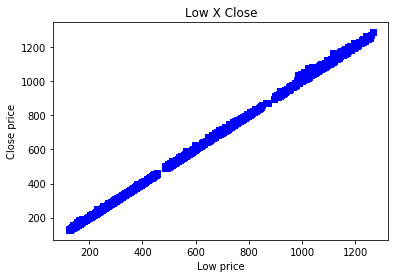

In [24]:
# Looking for outliers
plt.scatter(x = gg_data.Low, y = gg_data.Close, c = "blue", marker = "s")
plt.title("Low X Close")
plt.xlabel("Low price")
plt.ylabel("Close price")
plt.show()

Now we plot SalePrice with 'OverallQual' (Rates the overall material and finish of the house).
From the picture below, we can see that if the house is having better overal quality, then the price will also better.

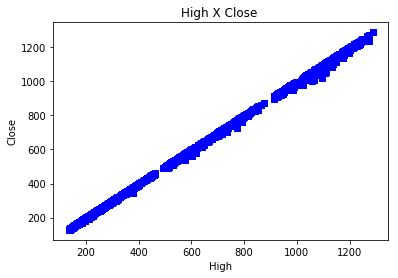

In [25]:
# Plot 'SalePrice' and 'OverallQual' (Rates the overall material and finish of the house)
plt.scatter(x = gg_data.High, y = gg_data.Close, c = "blue", marker = "s")
plt.title("High X Close ")
plt.xlabel("High")
plt.ylabel("Close")
plt.show()

We now plot SalePrice with 'ExterQual' (Evaluates the quality of the material on the exterior).
From the picture below, we can see that if the house is having better ExterQual(Evaluates the quality of the material on the exterior), then the price will also better.

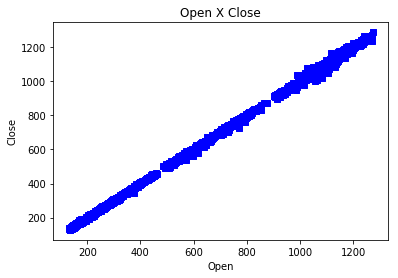

In [26]:
# Plot 'SalePrice' and 'ExterQual' (Evaluates the quality of the material on the exterior).
plt.scatter(x = gg_data.Open, y = gg_data.Close, c = "blue", marker = "s")
plt.title("Open X Close")
plt.xlabel("Open")
plt.ylabel("Close")
plt.show()

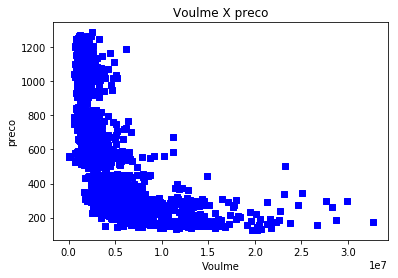

In [27]:
# Voulme X preco
plt.scatter(x = gg_data.Volume, y = gg_data.Close, c = "blue", marker = "s")
plt.title("Voulme X preco")
plt.xlabel("Voulme")
plt.ylabel("preco")
plt.show()

We see the distribution of label prices

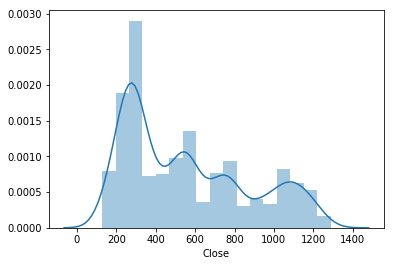

In [31]:
# Check the distribution of label values Close price
sbn.distplot(gg_data['Close'])


In [32]:
# Skewness metric
gg_data['Close'].skew()

0.6387987773928498

The skewness value > 1 ==> data is highly skewed. (Ref: https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55 ). We can use Logarithm transformation to normalize the SalePrice data. A normalized label helps in better modeling the close price between label values and independent features.

In [33]:
normalized_saleprice = np.log(gg_data['Close'])
print('Check skewness:', normalized_saleprice.skew())

Check skewness: -0.010577797260174262


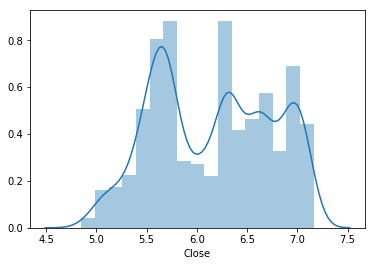

In [34]:
sbn.distplot(normalized_saleprice)

In [36]:
# We check the type of all columns in dataframe
gg_data.dtypes

Open        float64
High        float64
Low         float64
Close       float64
AdjClose    float64
Volume        int64
dtype: object

## Divide the gg_data into trainset and testset, then normalize x_train an x_test by using StandardScaler

In [37]:
# We use sklearn.model_selection import train_test_split to split the dataframe into trainset and testset
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
   
#Divide data into training set and test set = 70 % : 30%
trainset, testset = train_test_split(gg_data, test_size=0.3)

# Convert all columns with type integer (except SalePrice) to float 32 to save some memory.
trainset = trainset.astype('float64')#MUDEI DEPOIS QUE TUDO FUNCIONOU
testset = testset.astype('float64')
    
x_trainset = trainset.drop(['Close'],axis=1)
x_testset = testset.drop(['Close'],axis=1)
 
scaler = StandardScaler()

x_train = scaler.fit_transform(trainset.drop(['Close'],axis=1).values)
y_train = scaler.fit_transform(trainset['Close'].values.reshape(-1, 1))
y_train = np.ravel(y_train)

x_test = scaler.fit_transform(testset.drop(['Close'],axis=1).values)
y_test = scaler.fit_transform(testset['Close'].values.reshape(-1, 1))
y_test = np.ravel(y_test)

## GA_ANN Algorithm

**Step 1 Initial population function**

In [139]:
# Initial population function
# pop_size is the number of individuals (rows) in the initial population
# genesPerCh is the number of genes per each individual (features/ columns) 

def generate_pop (pop_size, genesPerCh):                   # assign randomly binary values to each individual
    chromosomes = np.array([np.random.choice([0,1], size=genesPerCh)for individual in range(pop_size)],dtype='int8')   
    return chromosomes   # return the initial population

**Step 2 Decode Function**

In [140]:
# Decode function
# pop is the population to be decoded
# np.argwhere return indices from non-zero genes and flattened the array with np.ravel
def decode_function(pop): 
    selected_features = np.array([np.ravel(np.argwhere(pop[i])) for i in range(pop.shape[0])])
    selected_features
    return selected_features         # return array with selected indices 

**Step 3 ANN Functions**

In [141]:
#ANN with SKlearn
from sklearn.neural_network import MLPRegressor  

def NeuralNetwork(train_x, train_y):
    mlp = MLPRegressor(hidden_layer_sizes=(10),
                       activation='relu',
                       solver='lbfgs',
                       max_iter=1,
                    )
 
    mlp.fit(train_x, train_y)  
    return mlp

def get_predictions_forTrain(features):
    #for given feature indexes, this function will get predictions from neural network for the specified features
    print('features {}'.format(features))
    mlp = NeuralNetwork(x_train[:,features], y_train)
    predictions = mlp.predict(x_train[:,features])
    return predictions

**Step 4 Fitness Function**

In [142]:
def fitness(pred, real):
    MSE_ANN = mean_squared_error(real , pred)
    RMSE_ANN = np.sqrt(MSE_ANN)
    return (1/RMSE_ANN) #fitness would be the inverse of roo mean square error

#### Step 5 Stopping criteria Fuction

In [143]:
def stoppingCriteria(fitness, pop, fitness_of_featuresSets, n):
    #This functions stops the iteration if after 20x5 iterations, the fitness drops, it takes the population from previous fitness STORED
    global temp_pop #The population which will be used as 
    global temp_fitness
    if len(fitness) < n: #No stopping until we reach nx5 iterations 
        return False
    elif len(fitness) == n: #At nx5th iteration, store the population and its fitness
        temp_pop = pop
        temp_fitness = fitness_of_featuresSets
        return False
    else:
        if fitness[-2] < fitness[-1]: #this means that fitness is increased after 5 iterations
            #keep on storing the latest population and respective fitness PASSED
            #This process can be complicated by using the n-5th and n-10th fitness value, but sometimes, it would take more iteration but the same best fitness
            temp_pop = pop
            temp_fitness = fitness_of_featuresSets
            return False
        else: #if it drops from the value 5 iterations before, stop the process
            return True #return true only when it is smaller than previous one. Temp_pop will be the previous population

**Step 6 Roulette Wheel Selection Function**

In [159]:
def RouletteWheel_Selection(pop,fitness):
    porps = (fitness/np.sum(fitness))  # calculate the proportions of all fitnesses   
    print('porps: {}'.format(porps))
    type(porps)
    fitness_pop = np.hstack([pop,porps]) # add the proportions to population
    print('fitness_pop: {}'.format(fitness_pop))
    type(porps)
    new_parents = np.zeros(pop.shape,dtype='int8')
    print('new_parents: {}'.format(new_parents))
    for chromosome in range(new_parents.shape[0]) :
        pick = np.random.uniform(0,1)         # pick random number from 0 to summation of proportions
        index = np.argwhere(fitness_pop[:,-1].cumsum()>pick)[0]  # go through the population and sum the fitnesses and 
        new_parents[chromosome] = fitness_pop[index,:-1]         # return the chromosome when the sum of fitnesses is 
                                                                 # greater than pick number
    return new_parents   # return the selected parents 

**Step 7 Uniform Crossover Function**

In [145]:
def uniformCrossover(population):
    offspring = np.zeros_like(population)
    p1 = population[::2] #Even indexes 0,2,4... would be parent 1
    p2 = population[1::2] #Odd indexes 1,3,5... would be parent 2
    if len(p1)!=len(p2): #If population size is odd the p1 would be larger thatn p2
        #We won't be doing the crossover of last individual of the mutation pool and copy it as it is to the offspring
        offspring[-1] = p1[-1]
        p1 = p1[:-1]
    swap = np.random.choice([True,False], size=p1.shape) #generate True or False of every parent set.
    #True means swap the cell from p1 with p1. False means no swapping
    #Even rows of offspring would be p1 and odd would be p2
    offspring[:-1:2] = np.where(swap, p2, p1) #if swap is true for a cell, even row would have p2 for that gene. Other-wise p1 
    offspring[1::2] = np.where(swap, p1, p2) #if swap is true for a cell, odd row would have p1 for that gene. Other-wise p2
    return offspring

**Step 8 Mutation**

In [146]:
# Mutiation function with default mutation probability as 0.3
def bitFlipMutation(offspring, p = 0.3):
    toMutate = np.sort(np.random.randint(offspring.shape[0], size=int(offspring.shape[0]*p))) #Select the chromosomes you want to apply Mutation on
    bitPos = np.random.randint(offspring[toMutate].shape[1], size=offspring[toMutate].shape[0]) #generate a random gene position to flip for selected chromosomes
    offspring[toMutate, bitPos] = np.where(offspring[toMutate, bitPos],0,1) #if value is 1, replace it by 0 and vice-versa
    return offspring

**MAIN Part**

**ESSA BOSTA TA RANDOMICA, SÓ FUNCIONA QUANDO QUER**

**NÃO MUDEI NADA E FUNCIONOU**

In [176]:
#size of the initial population
pop_size = 100

#the values is set to have mod5 = 1 for a complete plot
number_of_generations = 500

#Function to get prediction array corresponding to all the slected features in the population
pred_train = np.frompyfunc(get_predictions_forTrain, 1, 1) #eh func mesmo
type(pred_train)

#vectorized funtion to get the fitness of every individual in the population
fVec = np.vectorize(fitness, excluded=['real'], otypes=[np.float64]) 

#Names of feature
#house_features = pd.DataFrame(['Open', 'High', 'Low', 'AdjClose', 'Volume']) 
house_features = x_trainset.columns[:] #Names of features
house_features

#genes per chromosome
genesPerCh = 5
genesPerCh2 = house_features.size 
genesPerCh2

#Generate initial population. This will be updated in every generation
pop = generate_pop(pop_size, genesPerCh)

selected_features = decode_function(pop)

avgFitnessPerGeneration = [] #average of fitness values of the individuals in every fifth generation
maxFitnessPerGeneration = [] #maximum of fitness values of the individuals in every fifth generation
minFitnessPerGeneration = [] #minumum of fitness values of the individuals in every fifth generation


selected_features #normalize array of pop
new_array=selected_features
newer_array = np.array([y for y in new_array if 0 not in y.shape])

#newer_array

for iteration in range(number_of_generations):
    s_predictions = pred_train(newer_array) #predicted labels for train data for each individual in the population
    fitness_of_featuresSets = fVec(pred = s_predictions, real = y_train) #for every predicted array, get the fitness for each individual
    fitness_of_featuresSets = fitness_of_featuresSets.reshape(fitness_of_featuresSets.shape[0],1)  #taking the transpose to get proper dimensions for future computations
    
    print ('pop shape {} / fitness_of_featuresSets shape{}'.format(pop.shape, fitness_of_featuresSets.shape))
    
    
    if iteration%5 == 0: #max, min and average values will only be stored for every 5th iteration
        avgFitnessPerGeneration.append(np.mean(fitness_of_featuresSets))
        maxFitnessPerGeneration.append(np.max(fitness_of_featuresSets))
        minFitnessPerGeneration.append(np.min(fitness_of_featuresSets))
        if stoppingCriteria(maxFitnessPerGeneration, pop, fitness_of_featuresSets, n=15): #checking if the stopping criteria is met
            selectedPop = temp_pop #temp pop is selected to get the best individual
            fitnessForSelectedPop = temp_fitness #the corresponding fitness for the population
            indPos = np.argmax(fitnessForSelectedPop) #get the index where the best betness resides
            bestInd = selectedPop[indPos] #get the best pop corresponding to best fitness
            break  #no more generations if stopping criteria is met
    
    
    
    print ('pop {} / fitness_of_featuresSets {}'.format(pop, fitness_of_featuresSets))
    
    #RouletteWheel_Selection sort method
    mating_pool = RouletteWheel_Selection(pop, fitness_of_featuresSets)
    
    #CrossOver
    offspring = uniformCrossover(mating_pool) 
    
    #Mutation
    offspring = bitFlipMutation(offspring)
    
    #updating population for next generation
    pop = offspring
    
    #updating features for next iteration
    selected_features= decode_function(offspring)
    
    

features [2 3]
features [0 1 2 3 4]
features [3]
features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
fea

features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]

features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0

features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]


features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe637bdf2b0> / fitness_of_featuresSets sha

features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]


features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
fe

features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
f

features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features 

 [1.         0.         1.         0.         1.         0.01375004]]
new_parents: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0

features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features 

features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features 

features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features 

features [0 1 2 3 4]
features [3]
features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
f

features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features

features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features 

features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features 

features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe637bc8e40> / fitness_of_featuresSets shape<built-in method view of numpy.ndarray object at 0x7fe637c19a30>
pop [[0 1 1 1 0]
 [0 1 0 0 0]

features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
featu

features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
feature

features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
featu

features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features 

features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object a

features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
fe

features [2 3]
features [0 1 2 3 4]
features [3]
features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
fea

features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe637bf7210> / fitness_of_featuresSets sha

features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features

features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
featu

features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
feature

features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2

features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features

features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0

features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b574e0> / fitness_of_f

features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features 

features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy

features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features 

features [2 3]
features [0 1 2 3 4]
features [3]
features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
fea

features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe637c550d0> / fitness_of_featuresSets sha

features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b576c0> / fitness_of_featuresSets shape<built-in method view of numpy.ndarray object at 0x7fe637bf1440>
pop [[0 1 0 1 1]
 [1 0 1 0 1]
 [1 0 1 1 1]
 [1 0 0 0 1]
 [0 0 0 1 1]
 [0 1 1 1 1]
 [0 1 0 1 1]
 [0 0 0 0 1]


features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
fea

features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
featu

features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b57e90> / fitness_of_featuresSets shape<built-in method view of numpy.ndarray object at 0x7fe637bf1440>
pop [[0 0 1 1 1]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [0 0 0 1

features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe637bfe030> / fitness_of_featuresSets shape<built-in method view of numpy.ndarray object at 0x7fe637bf1440>
pop [[0 0 1 1 1]
 [0 1 0 1 0]
 [1 0 1 0 0]
 [1 1 1 1 0]
 [1 0 0 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 1 0]
 [0 0 1 1 0]
 [0 

features [2 3]
features [0 1 2 3 4]
features [3]
features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
fea

features [2]
features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
featu

features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
fea

features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy

features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
featu

features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
feature

features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b579e0> / fitness_of_featuresSets shape<built-in method view of num

features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features

features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
fea

features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features

features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features 

features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b57cb0> / fitness_of_featuresSets shape<built-in method view of numpy.ndarray object at 0x7fe637bf1440>
pop [[0 0 0 1 0]
 [1 0 1 0 0]

 [1.         1.         0.         0.         0.         0.0047236 ]]
new_parents: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0

features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features

features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0

features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features

features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features 

features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b57c60> / fitness_of_featuresSets shape<built-in method view of numpy.ndarray object at 0x7fe637bf1440>
pop [[0 1 

features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b57e90> /

features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b574e0> /

features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
feat

features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0

features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
feature

features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
fe

features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features 

features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features [0 2]
features [1]
features [2 3 4]
features [0 3 4]
features [0 3]
features [0 3 4]
features [0 2 3]
pop shape <built-in method view of numpy.ndarray object at 0x7fe635b57a30> / fitness_of_featuresSets sha

features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features 

features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features 

features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4

features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
feature

features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
fea

features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
feature

features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features 

features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features 

features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features 

features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2

features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
features [0 1]
features [4]
features [1]
features [4]
features [0 1 2 3 4]
features [0 2 3 4]
features [0]
features [1 2 3]
features [1 2 3 4]
features [0]
features [0 2 4]
features [4]
features [3]
features [0 3 4]
features [0]
features [0 1]
features [2 4]
features [0 2 3 4]
features [0 3 4]
features [0 3]
features [0 2 3]
features [0]
features [1 3 4]
features [2]
features [0 4]
features [0 1 2]
features

features [1 2 3]
features [0 1 3]
features [3]
features [3 4]
features [0 2 4]
features [0 3]
features [0 4]
features [0 4]
features [1 2 3]
features [0 1 2 3]
features [4]
features [1 2 3 4]
features [2]
features [1 2 4]
features [0 1 3 4]
features [4]
features [1 4]
features [1 2]
features [1 2 3 4]
features [0]
features [1 2 3]
features [0 1 2 4]
features [1 2 4]
features [2 3 4]
features [0 1 2 3 4]
features [0 1 2 3]
features [2]
features [3]
features [1 2 4]
features [1 3]
features [0 2 4]
features [0 1 2 3]
features [2 4]
features [1 4]
features [0 2 4]
features [0 1 2 4]
features [0]
features [0 4]
features [2 3]
features [1 3]
features [0 2 4]
features [0 2]
features [0 3]
features [0 1 2 3]
features [1 3 4]
features [1 4]
features [0 2 3]
features [0 2 3]
features [2]
features [1 4]
features [3 4]
features [4]
features [1 2]
features [1]
features [2]
features [2 4]
features [0 1 2]
features [2 4]
features [1 4]
features [0 1 2]
features [0 2]
features [1 3]
features [2 4]
fea

**ESSA BOSTA TA RANDOMICA, SÓ FUNCIONA QUANDO QUER**

"xh = (len(maxFitnessPerGeneration)-2)\nyh = np.max(temp_fitness)\n_= ax.annotate('Best population selected', \n                xy = (xh, yh), \n                xytext=(ax.get_xlim()[0]+xh-2.5, yh + 0.045),\n                arrowprops=dict(facecolor='green', headwidth=4, width=2,\n                                headlength=4),\n                horizontalalignment='left', verticalalignment='top', color='blue', size=15\n                )"

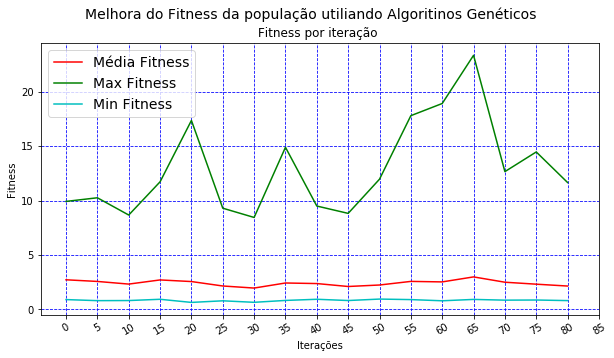

In [181]:
#plot fitnessPerGeneration
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
#set title of the graph/plot
ax.set_title('Fitness por iteração ')
#ax.set_xlabel('Date')
ax.plot(avgFitnessPerGeneration, 'r', label='Média Fitness')
ax.plot(maxFitnessPerGeneration, 'g', label='Max Fitness')
ax.plot(minFitnessPerGeneration, 'c', label='Min Fitness')
ax.legend(loc='best', prop={'size': 14}) 
_ = fig.suptitle('Melhora do Fitness da população utiliando Algoritinos Genéticos', fontsize=14)
ax.grid(color = 'b', linestyle='--')
xticks = list(range(0,len(maxFitnessPerGeneration)+1,1))
xticklabels = [x*5 for x in xticks]
props = {'xlabel': 'Iterações',
         'xticks': xticks,
         'ylabel': 'Fitness'
        }
_ = ax.set(**props)
labels = ax.set_xticklabels(xticklabels, rotation=30, fontsize='medium')
#Annotation

"""xh = (len(maxFitnessPerGeneration)-2)
yh = np.max(temp_fitness)
_= ax.annotate('Best population selected', 
                xy = (xh, yh), 
                xytext=(ax.get_xlim()[0]+xh-2.5, yh + 0.045),
                arrowprops=dict(facecolor='green', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top', color='blue', size=15
                )"""

#### The most important features that give the best fitness are:

In [182]:
print(np.ravel(house_features[np.argwhere(bestInd)]))

['Low' 'Volume']


**Evaluate with the test set**

In [183]:
def get_predictions_forTest(features):
    #for given feature indexes, this function will get predictions from neural network for the specified features
    mlp = NeuralNetwork(x_train[:,features], y_train)
    predictions = mlp.predict(x_test[:,features])
    return predictions

In [184]:
# get predictions on testset
pred_test = np.frompyfunc(get_predictions_forTest, 1, 1) #Function to get prediction array corresponding to all the slected features
print('pred_test {}'.format(pred_test))

selected_features_test = decode_function(selectedPop) #get selected features by GA
print('selected_features_test {}'.format(selected_features_test))

new_array=selected_features_test
newer_array = np.array([y for y in new_array if 0 not in y.shape])

newer_array

s_predictions_test = pred_test(newer_array) #predicted labels for test set
print('s_predictions_test {}'.format(s_predictions_test))

fitness_of_featuresSets_test = fVec(pred = s_predictions_test, real = y_test) #for every predicted array, get the fitness for each individual

fitness_of_featuresSets_test = fitness_of_featuresSets_test.reshape(fitness_of_featuresSets_test.shape[0],1)  #taking the transpose to get proper dimensions for future computations

pred_test <ufunc '? (vectorized)'>
selected_features_test [array([1]) array([1, 2, 4]) array([1, 2, 4]) array([0, 2, 3, 4])
 array([0, 3, 4]) array([2, 4]) array([], dtype=int64)
 array([], dtype=int64) array([2, 3]) array([0, 3]) array([2]) array([3])
 array([0, 1, 2, 3]) array([0, 1, 3, 4]) array([1, 2, 3]) array([0, 4])
 array([0, 1, 4]) array([1, 2, 3, 4]) array([3, 4]) array([3, 4])
 array([0, 3]) array([0, 1, 3]) array([0, 1, 2, 4]) array([1, 2, 3])
 array([2, 4]) array([2, 3]) array([2, 3, 4]) array([1, 2, 4]) array([1])
 array([1, 2, 3]) array([0, 3, 4]) array([0, 2, 4]) array([1, 4])
 array([2, 4]) array([0, 2]) array([1, 2, 4]) array([1, 2, 3, 4])
 array([1, 2, 3]) array([0, 1, 2, 4]) array([1, 3]) array([0, 3, 4])
 array([4]) array([1, 2, 3]) array([0, 1, 2, 3]) array([0, 2, 3])
 array([0, 3, 4]) array([1, 2, 3, 4]) array([0, 3]) array([0, 3])
 array([0, 2, 4]) array([2, 4]) array([0, 1, 2, 3, 4]) array([1])
 array([1, 2, 3]) array([0, 1, 2, 3]) array([2, 3, 4]) array([1, 2,

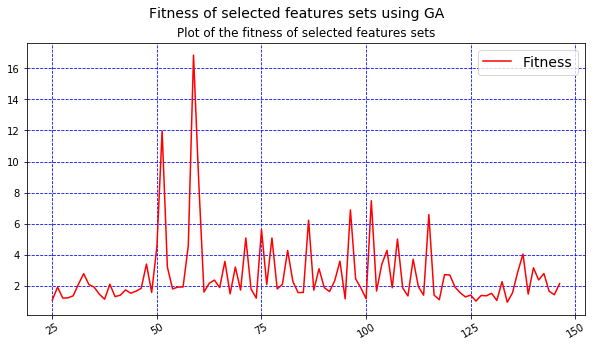

In [186]:
#plot fitness_of_featuresSets_test
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
#set title of the graph/plot
ax.set_title('Plot of the fitness of selected features sets')

ax.plot(fitness_of_featuresSets_test, 'r', label='Fitness')
ax.legend(loc='best', prop={'size': 14}) 
_ = fig.suptitle('Fitness of selected features sets using GA', fontsize=14)
ax.grid(color = 'b', linestyle='--')
xticks = list(range(0,len(fitness_of_featuresSets_test)+1,5))
xticklabels = [x*5 for x in xticks]

labels = ax.set_xticklabels(xticklabels, rotation=30, fontsize='medium')

In [187]:
# Denormalize data after normalizing to get original scale of values

def denormalize(dataset, scaled_data):
    dataset = dataset['Close'].values.reshape(-1,1)
    normalized_data = scaled_data.reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit_transform(dataset)
    return scaler.inverse_transform(normalized_data)

In [188]:
# denormalize y test and predictions
de_y_test = denormalize(testset, y_test)
de_pred = denormalize(testset, s_predictions_test)
# de_pred = np.abs(de_pred)
# make the predictions array flat
fitness_values = np.ravel(fitness_of_featuresSets_test)

de_pred_max = de_pred[np.argmax(fitness_values)][0] # predictions with max fitness in selected features set
de_pred_min = de_pred[np.argmin(fitness_values)][0] # and min fitness

# index of fitness value that's nearest to the average fitness of selected features set
average_idx = (np.abs(fitness_values - np.average(fitness_values))).argmin()
de_pred_average = de_pred[average_idx][0]

In [226]:
def plot_test_result(pred, test_y, fra=0, color='blue', label='predictions'):
    #Plotting real value against prediction value over a period
    fig = plt.figure(1, figsize=(8,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("Predição dos preços de fechamento da empresa Google", fontsize=12)
    ax.plot(test_y[fra:], color='red', label='Valor real', linewidth=1)
    ax.plot(pred[fra:], color=color, label=label, linewidth=1)
        
    ax.legend(loc='best')
    plt.ylabel('Preço')
    plt.show()

In [227]:
def mse_result(test, pred):
    MSE = mean_squared_error(test , pred) 
    RMSE = np.sqrt(MSE)
    fitness = 1/RMSE
    print("MSE %.4f"% MSE)
    print("RMSE %.4f"% RMSE)
    print("Fitness %.8f"% fitness)

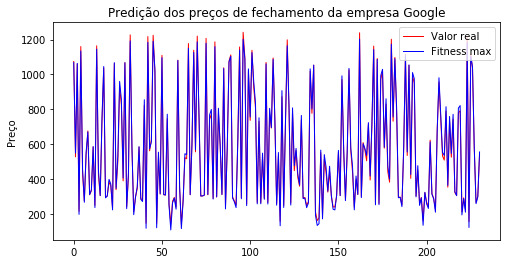

In [228]:
plot_test_result(de_pred_max, de_y_test, fra=600, label='Fitness max')

In [229]:
mse_result(de_y_test , de_pred_max)

MSE 352.2480
RMSE 18.7683
Fitness 0.05328141


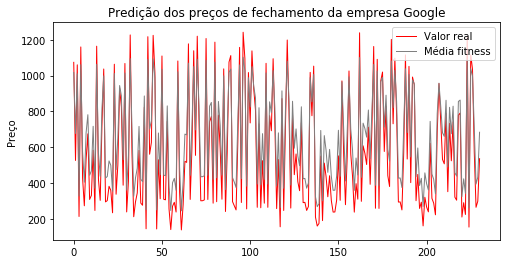

In [230]:
plot_test_result(de_pred_average, de_y_test, fra=600, color='gray', label='Média fitness')

In [231]:
mse_result(de_y_test , de_pred_average)

MSE 13628.2994
RMSE 116.7403
Fitness 0.00856602


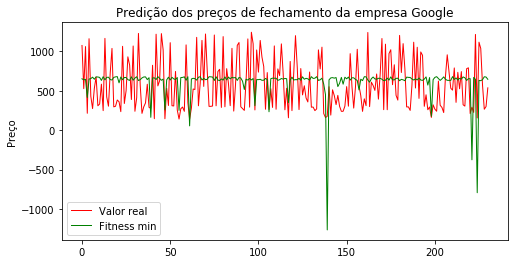

In [232]:
plot_test_result(de_pred_min, de_y_test, fra=600, color='green', label='Fitness min')

In [233]:
mse_result(de_y_test , de_pred_min)

MSE 110378.5689
RMSE 332.2327
Fitness 0.00300994


### Prices's prediction without feature selection:

In [234]:
# create mlp model, then we fit the training data to the model and we use x_test to get the predictions
mlp = MLPRegressor(hidden_layer_sizes=(10),activation='relu',solver='lbfgs',max_iter=1,)
mlp.fit(x_train, y_train)  
pred = mlp.predict(x_test)

In [235]:
# Denormalize the data to get the original scale of values
de_pred = denormalize(testset, pred)
mse_result(de_y_test, de_pred)

MSE 51576.7600
RMSE 227.1052
Fitness 0.00440325


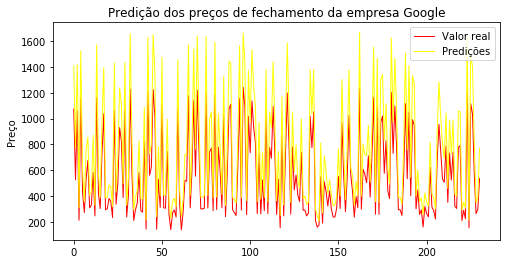

In [236]:
# Plot real values against prediction values 
plot_test_result(de_pred, de_y_test, fra=600, color='yellow', label='Predições')